## Predict number of diners in a restaurant using a SARIMAX model

## In this project, we have a dataset (a real dataset from kaggle competition) consisting of the number of visitors in 4 restaurants in a time series format. We aim to build a SARIMA model first to check the performance of the forecast. 



## The dataset also contains additional info such as day of the week and whether or not it is a holiday. This additional info are exogenous variables which we incorporate in the later part of the project to build a SARIMAX model. We will then end off by comparing the performance of the 2 models.

In [1]:
# Import the necessary libraries 
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('C:/Users/Eugene Yee/Desktop/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

## Data Inspection

This dataset was inspired by a Kaggle competition. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 517 entries, 2016-01-01 to 2017-05-31
Freq: D
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weekday       517 non-null    object 
 1   holiday       517 non-null    int64  
 2   holiday_name  517 non-null    object 
 3   rest1         478 non-null    float64
 4   rest2         478 non-null    float64
 5   rest3         478 non-null    float64
 6   rest4         478 non-null    float64
 7   total         478 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 36.4+ KB


In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [3]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [4]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [5]:
# Change the dtype of selected columns from float to int 
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2016-01-01 to 2017-04-22
Freq: D
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weekday       478 non-null    object
 1   holiday       478 non-null    int64 
 2   holiday_name  478 non-null    object
 3   rest1         478 non-null    int32 
 4   rest2         478 non-null    int32 
 5   rest3         478 non-null    int32 
 6   rest4         478 non-null    int32 
 7   total         478 non-null    int32 
dtypes: int32(5), int64(1), object(2)
memory usage: 44.3+ KB


## Visualize the data

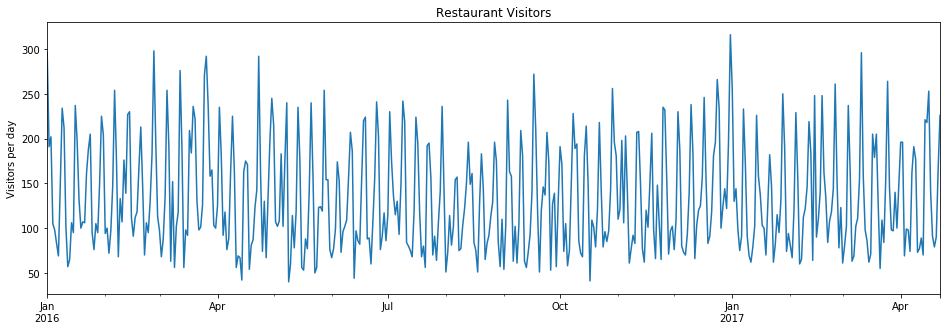

In [6]:
# Let's have a look at the distribution of visitors per day across the period
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## From the plot above, we observe that there is some seasonality in the data. With some basic domain knowledge about restaurants, we do know that restaurants tend to get more busy (i.e more visitors) during the weekends or public holidays. To explore this, let's plot the holidays on top of the graph that we've obtained earlier

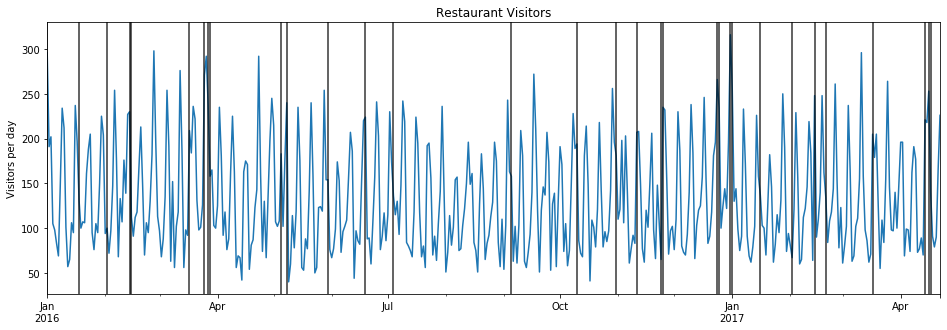

In [21]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.8);  # This grey line indicates that there is a holiday

## Run an ETS Decomposition

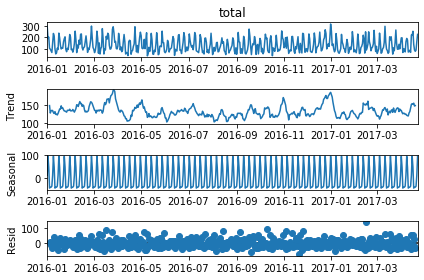

In [22]:
result = seasonal_decompose(df1['total'])
result.plot();

## Test the data for stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Run pmdarima.auto_arima to obtain recommended orders

The orders obtained are: ARIMA ORDER OF (1,0,0) and SEASONAL ORDER of (2,0,0,7)

In [24]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2384.133
Date:                   Sun, 26 Feb 2023   AIC                           4776.267
Time:                           18:43:01   BIC                           4792.945
Sample:                       01-01-2016   HQIC                          4782.824
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.4421      1.822      2.986      0.003       1.870       9.014
ar.S.L7        0.9596      0.013     71.796      0.000       0.933       0.986
ma.S.L7       -0.7386      0.050    -14.634      0.000      -0.838      -0.640
sigma2      1237.8918     74.072     16.712      0.000    1092.713    1383.071
===================================================================================
Ljung-Box (L1) (Q):                  15.96   Jarque-Bera (JB):                58.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.72
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Split the data into train/test sets¶
We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [12]:
len(df1)

478

In [13]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

Fit a SARIMA(1,0,0)(2,0,0,7) Model
NOTE: To avoid a ValueError: non-invertible starting MA parameters found we're going to set enforce_invertibility to False.

In [14]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Sun, 26 Feb 2023   AIC                           4457.403
Time:                                   18:27:14   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                29.23
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

## Let's visualize the predictions against the test set

It seems that the SARIMA model is not doing a good job in predicting the spikes. The black lines indicate that a holiday exist and for the first holiday (17th Apr) in the plot below, the model over-estimated the value. 

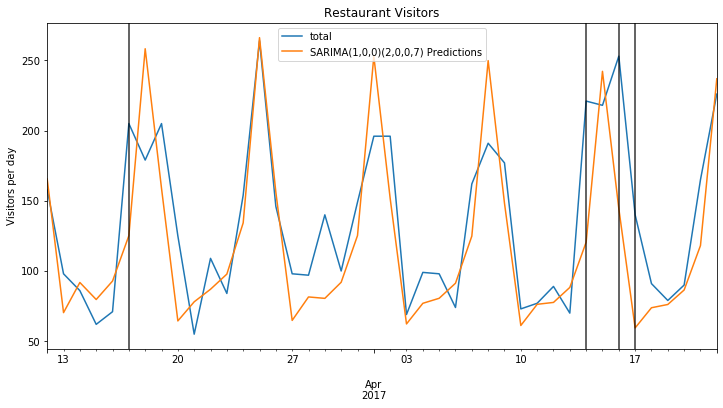

In [25]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.8);

Let's quantify the results and obtain the RMSE metrics

In [17]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647956
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315494


## Moving on, we will be including the exogenous variable (holiday) and build a SARIMAX model and compare the performance against the SARIMA model that we've just built.

In [26]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2094.013
Date:                           Sun, 26 Feb 2023   AIC                           4200.027
Time:                                   18:45:07   BIC                           4224.493
Sample:                               01-01-2016   HQIC                          4209.682
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       70.6559      4.264     16.569      0.000      62.298      79.014
ar.L1          0.9999      0.001   1549.528      0.000       0.999       1.001
ma.L1         -0.9991      0.003   -286.850      0.000      -1.006      -0.992
ar.S.L7        0.9998      0.000   3537.280      0.000       0.999       1.000
ma.S.L7       -0.9618      0.029    -33.471      0.000      -1.018      -0.905
sigma2       808.8842     47.772     16.932      0.000     715.252     902.516
===================================================================================
Ljung-Box (L1) (Q):                  15.17   Jarque-Bera (JB):                23.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.28
Prob(H) (two-sided):                  0.94   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,1)(1,0,1,7) Predictions')

## Let's visualize the results from the SARIMAX model

By visually inspecting, we can oberserve that the SARIMAX performs better as it does not over-estimate the values during the spikes and during the holidays

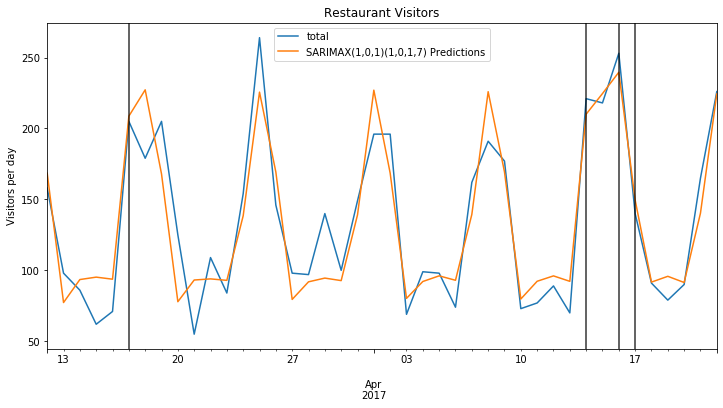

In [35]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.8);

## Let's check out the metrics

The SARIMAX model performs almost twice better than the SARIMA model and this shows that adding the exogenous variables are of a huge impact to the model performance

In [29]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647956
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315494

SARIMAX(1,0,0)(2,0,0,7) MSE Error:  510.685276
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 22.59834675


## Model Evaluation

Obtained RMSE value = 22.59 while the mean number of visitors/diners in total = 133.79
By taking (22.59/133.79)*100, we get a mean error of ~16.88% of the mean value of the dataset.

In [45]:
df1.describe()

,holiday,rest1,rest2,rest3,rest4,total
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,0.066946,37.533473,27.163180,31.548117,37.548117,133.792887
std,0.250190,21.499791,15.731851,17.820112,24.614955,59.736116
min,0.000000,1.000000,1.000000,6.000000,3.000000,40.000000
25%,0.000000,22.250000,15.000000,18.000000,19.000000,86.000000
50%,0.000000,33.000000,25.000000,24.000000,30.000000,119.000000
75%,0.000000,49.000000,38.000000,45.000000,50.000000,176.750000
max,1.000000,128.000000,91.000000,99.000000,139.000000,316.000000


## Now let's do some forecasting by using the whole dataset to train a new SARIMAX model and predict into the unknown future

In [36]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,1)(1,0,1,7) Forecast into future')

This is an overall picture of the dataset and forecasted values

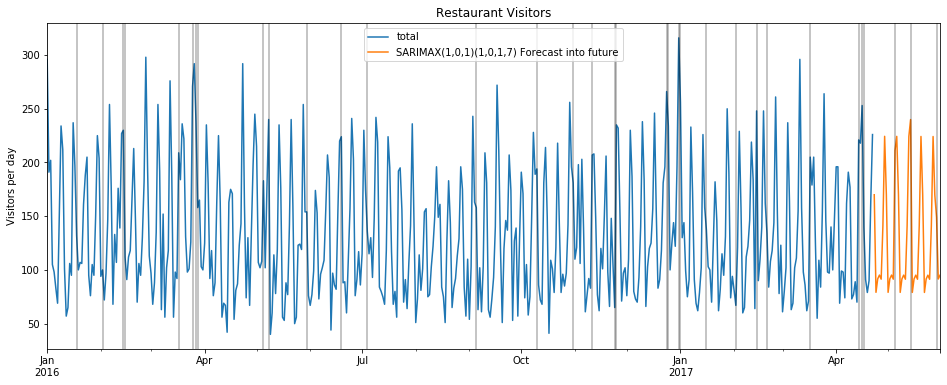

In [37]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);


Let's zoom into the last part of plot. We do not really have a way of telling whether the predictions are good or not since these are predictions into the unknown future. But the data does seem pretty reasonable as data keeps up with the weekday/weekend seasonality. 

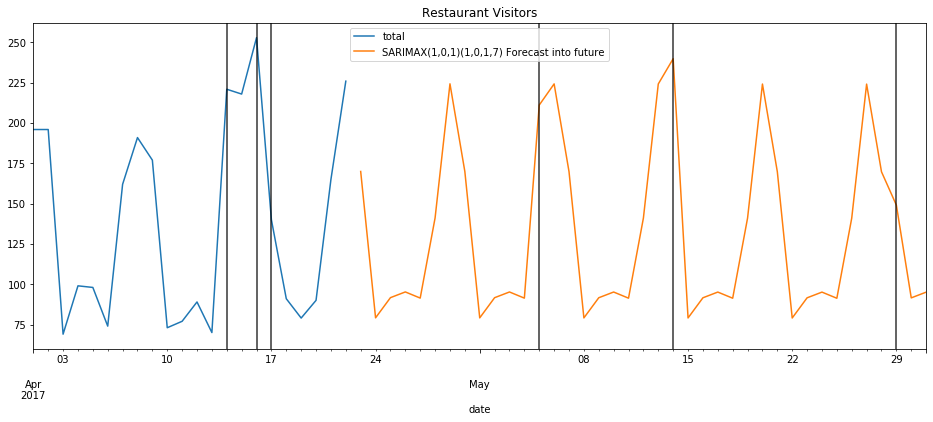

In [39]:
# Plot the forecast alongside historical values
ax = df1['total'].loc['2017-04-01':].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)

for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.8);

## Conclusion

Given the earlier metrics evaluation of RMSE and mean values, the SARIMAX model performance was not really the best. An updated version of this project should further research/improvements can looked into areas such as 
1) Hyperparameter tuning for the values of p, d, q and P, D, Q, s correctly. Maybe can use grid search to find the optimal values. 
2) Regularize the model by using L1 or L2 regularization techniques to prevent overfitting and improve the model's performance.
3) Get a larger training dataset
4) Explore state space model, deep learning models and gradient boosting models

Some of the valuable insights that can be drawn from this project (assuming this is a real piece of work for restaurants) is that the model is able to do a rather good job in predicting the number of visitors in any given day of the year. By knowing this info, we can provide business intelligence to the management during stakeholder meetings. With this info, management of the restaurants can then better prepare to deal with the highs and lows (seasonality) of the number of visitors from day to day. 

I never once worked as a management position in restaurants but to the best of my domain knowledge, the management can better manage the staff roster (i.e to deploy the correct number of waiters/chefs during the peaks) so that there is sufficient staff to deal with seasonality demand and vice-versa. A question to the viewers: "How many times do you see a restaurant whereby there is so little diners but yet so many staff members and vice versa?" With this analytics and prediction from the model, the restaurant can achieve the best staff:diner ratio and this can be potentially economical to the restaurant in terms of budgetting for the wages expenditure (they do not over hire/deploy staff nor understaff).

Another advantage can be forward planning of placing ingredient orders from the kitchen. Knowing the demand from the model predictions, the kitchen management can better manage their food/ingredient inventory to prevent wastage/expiration/excess food problems.

In summary, a restaurant can save alot of money by achieving the a good staff:diner ratio and not over/under-stocking their kitchen ingredients with the help of Data Science and Artificial Intelligence :)

## Author By: Eugene Yee
## Date: 26 Feb 2023